<a href="https://colab.research.google.com/github/mbenedicto99/RUNDECK_AI/blob/main/EWMA%2BCUSUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# -*- coding: utf-8 -*-
"""
base.py — Monitoramento temporal de falhas em JOBs (EWMA + CUSUM) com múltiplos CSVs

- Por padrão, lê TODOS os CSVs que começam com 'Relatorio' em ./data (glob: data/Relatorio*.csv).
- Também aceita:
    * múltiplos --csv (pode repetir a flag ou usar lista separada por vírgulas)
    * --csv-glob "data/Relatorio-*.csv" para controle fino
- Agrega falhas por janelas (FREQ) e calcula:
    * EWMA + limites (aprox. Poisson)  -> alert_ewma
    * CUSUM (lado positivo)            -> alert_cusum
- Combina alertas, ranqueia janelas por 'risk_score' e salva em ./data.
- Gera features por Job para modelagem futura.
- Mantém diretórios: ./data, ./scripts, ./models e salva parâmetros em models/monitor_params.json.

Exemplos:
    # usa todos os CSVs 'Relatorio*.csv' de ./data
    python base.py

    # arquivos específicos
    python base.py --csv data/Relatorio-A.csv --csv data/Relatorio-B.csv

    # lista separada por vírgulas
    python base.py --csv data/Relatorio-A.csv,data/Relatorio-B.csv

    # via glob customizado
    python base.py --csv-glob "data/Relatorio-2025-09-*.csv"

Requisitos: Python 3.10+ | pandas, numpy
Ubuntu 24.04:
    python3 -m pip install pandas numpy
"""
import argparse
import json
from dataclasses import dataclass
from glob import glob
from pathlib import Path
from typing import Iterable, Tuple, List, Sequence

import numpy as np
import pandas as pd


# =========================
# Config e parsing de args
# =========================
@dataclass
class Config:
    csv_paths: List[str]   # múltiplos CSVs
    outdir: Path           # ./data
    scripts_dir: Path      # ./scripts
    models_dir: Path       # ./models
    freq: str
    span: int
    z: float
    cusum_k: float
    cusum_h: float
    top_jobs: int


DEFAULT_GLOB = "data/Relatorio*.csv"  # <- somente arquivos iniciando com 'Relatorio'


def _find_all_csv_by_pattern(pattern: str = DEFAULT_GLOB) -> List[str]:
    return sorted(glob(pattern))


def _normalize_csv_args(csv_args: Sequence[str] | None, csv_glob: str | None) -> List[str]:
    paths: List[str] = []
    # --csv pode vir repetido e/ou com vírgulas
    if csv_args:
        for item in csv_args:
            parts = [p.strip() for p in item.split(",") if p.strip()]
            paths.extend(parts)
    # --csv-glob (se não vier, usamos o DEFAULT_GLOB)
    if csv_glob:
        paths.extend(glob(csv_glob))
    if not csv_args and not csv_glob:
        # padrão: somente 'Relatorio*.csv' no diretório data/
        paths = _find_all_csv_by_pattern(DEFAULT_GLOB)

    # Filtra existentes e remove duplicados preservando ordem
    seen = set()
    clean = []
    for p in paths:
        if not Path(p).exists():
            continue
        if p not in seen:
            clean.append(p)
            seen.add(p)
    return clean


def parse_args(argv=None) -> Config:
    p = argparse.ArgumentParser(description="Análise temporal de falhas em JOBs (EWMA + CUSUM) com múltiplos CSVs")
    p.add_argument("--csv", dest="csv_paths", action="append", required=False,
                   help="Caminho(s) CSV. Pode repetir a flag ou passar lista separada por vírgulas.")
    p.add_argument("--csv-glob", type=str, default=None,
                   help=f"Padrão glob (default implícito: '{DEFAULT_GLOB}').")
    p.add_argument("--outdir", type=str, default="data", help="Diretório de saída (default: data)")
    p.add_argument("--scripts-dir", type=str, default="scripts", help="Diretório para scripts (default: scripts)")
    p.add_argument("--models-dir", type=str, default="models", help="Diretório para modelos (default: models)")
    p.add_argument("--freq", type=str, default="15min", help="Frequência (ex.: 5min, 15min, 1h)")
    p.add_argument("--span", type=int, default=8, help="Span do EWMA (default: 8)")
    p.add_argument("--z", type=float, default=3.0, help="Multiplicador de sigma (default: 3.0)")
    p.add_argument("--cusum-k", type=float, default=0.5, help="Parâmetro k do CUSUM (default: 0.5)")
    p.add_argument("--cusum-h", type=float, default=5.0, help="Limiar h do CUSUM (default: 5.0)")
    p.add_argument("--top-jobs", type=int, default=10, help="N de jobs em ts_by_job (default: 10)")

    # Ignora args do kernel (-f ...) quando em Jupyter/Colab
    a, unknown = p.parse_known_args(argv)
    try:
        from IPython import get_ipython
        in_notebook = get_ipython() is not None
    except Exception:
        in_notebook = False
    if unknown and not in_notebook:
        print(f"[WARN] Ignorando argumentos desconhecidos: {unknown}")

    csv_paths = _normalize_csv_args(a.csv_paths, a.csv_glob)
    if not csv_paths:
        raise SystemExit(f"Nenhum CSV encontrado. Coloque arquivos que iniciem com 'Relatorio' em ./data "
                         f"ou use --csv / --csv-glob.")

    return Config(
        csv_paths=csv_paths,
        outdir=Path(a.outdir),
        scripts_dir=Path(a.scripts_dir),
        models_dir=Path(a.models_dir),
        freq=a.freq,
        span=a.span,
        z=a.z,
        cusum_k=a.cusum_k,
        cusum_h=a.cusum_h,
        top_jobs=a.top_jobs,
    )


# ===========
# Utilidades
# ===========
def _clean_cols(cols: Iterable[str]) -> List[str]:
    return [str(c).replace("\ufeff", "").strip() for c in cols]


# =======================
# 1) Leitura e limpeza
# =======================
REQUIRED_COLS = {"Ended Status", "Start Time", "End Time", "Job"}

def _load_one_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, sep=None, engine="python")
    df.columns = _clean_cols(df.columns)

    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        print(f"[WARN] {csv_path}: colunas ausentes {missing} — arquivo ignorado.")
        return pd.DataFrame(columns=list(REQUIRED_COLS))

    df["Ended Status"] = df["Ended Status"].astype(str).str.lower().str.strip()
    df["status"] = df["Ended Status"].map({"fail": 1, "succeed": 0})

    # Datas (ajuste o formato caso necessário)
    df["Start Time"] = pd.to_datetime(df["Start Time"], format="%d/%m/%y %H:%M:%S", errors="coerce")
    df["End Time"]   = pd.to_datetime(df["End Time"],   format="%d/%m/%y %H:%M:%S", errors="coerce")

    df = df.dropna(subset=["End Time"])
    df["duration_s"] = (df["End Time"] - df["Start Time"]).dt.total_seconds()
    df["duration_s"] = df["duration_s"].fillna(0).clip(lower=0)

    df["Job"] = df["Job"].astype(str).str.strip()
    df["__source_csv__"] = csv_path
    return df


def load_runs_many(csv_paths: Sequence[str]) -> pd.DataFrame:
    frames = []
    for p in csv_paths:
        try:
            df = _load_one_csv(p)
            if not df.empty:
                frames.append(df)
        except Exception as e:
            print(f"[WARN] Falha ao ler {p}: {e}")
    if not frames:
        return pd.DataFrame(columns=list(REQUIRED_COLS))
    df_all = pd.concat(frames, ignore_index=True)
    # ordena por End Time para robustez
    if "End Time" in df_all.columns:
        df_all = df_all.sort_values("End Time").reset_index(drop=True)
    return df_all


# ======================
# 2) Séries temporais
# ======================
def failures_global(df: pd.DataFrame, freq: str) -> pd.Series:
    """Contagem de falhas por janela temporal (freq)."""
    freq = freq.lower()
    fail_mask = df["status"] == 1
    ts = (
        df.loc[fail_mask]
        .set_index("End Time")
        .assign(cnt=1)
        .resample(freq)["cnt"]
        .sum()
        .fillna(0.0)
        .astype(float)
    )
    return ts


def failures_by_top_jobs(df: pd.DataFrame, freq: str, top_jobs: int) -> pd.DataFrame:
    """Matriz (tempo x job) com contagem de falhas para os TOP-N jobs por frequência de falha."""
    freq = freq.lower()
    fail_mask = df["status"] == 1
    top = df.loc[fail_mask, "Job"].value_counts().head(top_jobs).index.tolist()
    if not top:
        return pd.DataFrame()
    mat = (
        df.loc[fail_mask & df["Job"].isin(top)]
        .set_index("End Time")
        .groupby("Job")
        .resample(freq)["Ended Status"]
        .count()
        .unstack(0)
        .fillna(0.0)
        .sort_index()
        .astype(float)
    )
    return mat


# ===========================
# 3) EWMA + Limites + CUSUM
# ===========================
def ewma_limits(counts: pd.Series, span: int = 8, z: float = 3.0) -> pd.DataFrame:
    """
    EWMA da contagem; limites baseados em var ≈ mean (Poisson-like).
    risk_score: excesso acima de lim_up, normalizado (proxy de severidade).
    """
    s = counts.astype(float).copy()
    ew = s.ewm(span=span, adjust=False).mean()
    sigma = np.sqrt(np.maximum(ew, 1.0))  # sd ~ sqrt(lambda)
    lim_up = ew + z * sigma
    lim_lo = np.maximum(ew - z * sigma, 0.0)

    out = pd.DataFrame({"count": s, "ewma": ew, "lim_lo": lim_lo, "lim_up": lim_up})

    alert_ewma = (out["count"] > out["lim_up"]).astype(bool)
    above = (out["count"] - out["lim_up"]).clip(lower=0.0)
    denom = np.sqrt(out["lim_up"].replace(0.0, 1.0))
    risk_score = (above / denom).fillna(0.0)

    out["alert_ewma"] = alert_ewma
    out["risk_score"] = risk_score
    return out


def cusum_pos(counts: pd.Series, k: float = 0.5, h: float = 5.0) -> pd.Series:
    """
    CUSUM (lado positivo) -> Série int (0/1) com mesmo índice de 'counts'.
    """
    x = counts.astype(float).values
    mu = float(np.mean(x))
    sd = float(np.std(x)) + 1e-9
    s = (x - mu) / sd
    g = np.zeros_like(s)
    alarms = np.zeros_like(s, dtype=int)
    for i in range(1, len(s)):
        g[i] = max(0.0, g[i - 1] + s[i] - k)
        if g[i] > h:
            alarms[i] = 1
            g[i] = 0.0  # reset opcional
    return pd.Series(alarms, index=counts.index, name="alert_cusum")


# ==========================================
# 4) Features em janelas (para modelagem)
# ==========================================
def make_rolling_features(
    df_runs: pd.DataFrame,
    group_cols: Tuple[str, ...] = ("Job",),
    freq: str = "15min",
    windows: Tuple[str, ...] = ("15min", "30min", "1h", "3h"),
) -> pd.DataFrame:
    """
    Para cada grupo (ex.: Job), gera contagens de falhas por janela e
    soma móvel em múltiplas janelas + tempo desde a última falha (min).
    """
    # Normaliza
    freq = freq.lower()
    windows = tuple(w.lower() for w in windows)

    d = (
        df_runs.assign(flag=df_runs["status"].astype(int))
        .set_index("End Time")
        .sort_index()
    )
    if d.index.size == 0:
        return pd.DataFrame()

    idx = pd.date_range(d.index.min().floor(freq), d.index.max().ceil(freq), freq=freq)
    feats = []
    for keys, g in d.groupby(list(group_cols)):
        s = (
            g[g["status"] == 1]
            .assign(cnt=1)["cnt"]
            .resample(freq)
            .sum()
            .reindex(idx)
            .fillna(0.0)
        )
        df_feat = pd.DataFrame(index=idx)
        keys_tuple = keys if isinstance(keys, tuple) else (keys,)
        for name, val in zip(group_cols, keys_tuple):
            df_feat[name] = val
        df_feat["cnt"] = s.astype(float)

        for w in windows:
            df_feat[f"cnt_{w}"] = s.rolling(w, min_periods=1).sum().astype(float)

        last_idx = None
        ttl = []
        for t, v in s.items():
            if v > 0:
                last_idx = t
                ttl.append(0.0)
            else:
                ttl.append(((t - last_idx).total_seconds() / 60.0) if last_idx else np.nan)
        df_feat["mins_since_last_fail"] = ttl

        feats.append(df_feat.reset_index(names="ts"))
    out = pd.concat(feats, ignore_index=True) if feats else pd.DataFrame()
    return out


# =======================
# 5) Execução principal
# =======================
def main(cfg: Config) -> None:
    # Garante diretórios
    cfg.outdir.mkdir(parents=True, exist_ok=True)
    cfg.scripts_dir.mkdir(parents=True, exist_ok=True)
    cfg.models_dir.mkdir(parents=True, exist_ok=True)

    # Carrega múltiplos CSVs
    df = load_runs_many(cfg.csv_paths)
    if df.empty:
        raise SystemExit("Nenhuma linha válida após leitura dos CSVs.")

    # Séries
    ts_global = failures_global(df, cfg.freq)
    ts_by_job = failures_by_top_jobs(df, cfg.freq, cfg.top_jobs)

    if ts_global.empty:
        for name in ("alerts_global.csv", "ts_by_job.csv", "rolling_features.csv", "windows_at_risk.csv"):
            (pd.DataFrame()).to_csv(cfg.outdir / name, index=False)
        meta = {
            "csv_used": [str(Path(p).resolve()) for p in cfg.csv_paths],
            "freq": cfg.freq, "span": cfg.span, "z": cfg.z,
            "cusum_k": cfg.cusum_k, "cusum_h": cfg.cusum_h, "top_jobs": cfg.top_jobs,
            "note": "Sem dados suficientes para agregação na frequência escolhida."
        }
        (cfg.models_dir / "monitor_params.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
        print("[WARN] Série global vazia. Saídas vazias geradas.")
        return

    # EWMA + CUSUM
    ew = ewma_limits(ts_global, span=cfg.span, z=cfg.z)
    cus = cusum_pos(ts_global, k=cfg.cusum_k, h=cfg.cusum_h)

    # Consolida e normaliza tipos (evita TypeError no '|')
    alerts = pd.concat([ew, cus], axis=1)
    alerts["alert_ewma"] = alerts["alert_ewma"].fillna(False).astype(bool)
    alerts["alert_cusum"] = alerts["alert_cusum"].fillna(0).astype(int).astype(bool)
    alerts["alert"] = np.logical_or(alerts["alert_ewma"], alerts["alert_cusum"]).astype(int)

    # Ranking de janelas por risco
    windows_at_risk = (
        alerts.assign(ts=alerts.index)
        .sort_values(["risk_score", "count", "ts"], ascending=[False, False, False])
        .reset_index(drop=True)
    )

    # Features por Job
    rolling_feats = make_rolling_features(df, group_cols=("Job",), freq=cfg.freq)

    # Salva ./data
    alerts.to_csv(cfg.outdir / "alerts_global.csv", index=True)
    (ts_by_job if ts_by_job is not None and not ts_by_job.empty else pd.DataFrame()).to_csv(
        cfg.outdir / "ts_by_job.csv", index=True
    )
    (rolling_feats if rolling_feats is not None and not rolling_feats.empty else pd.DataFrame()).to_csv(
        cfg.outdir / "rolling_features.csv", index=False
    )
    (windows_at_risk if windows_at_risk is not None and not windows_at_risk.empty else pd.DataFrame()).to_csv(
        cfg.outdir / "windows_at_risk.csv", index=False
    )

    # Metadados ./models
    meta = {
        "csv_used": [str(Path(p).resolve()) for p in cfg.csv_paths],
        "freq": cfg.freq, "span": cfg.span, "z": cfg.z,
        "cusum_k": cfg.cusum_k, "cusum_h": cfg.cusum_h, "top_jobs": cfg.top_jobs,
        "period_start": str(ts_global.index.min()),
        "period_end": str(ts_global.index.max()),
        "n_alert_points": int(alerts["alert"].sum()),
        "rows_loaded": int(len(df)),
    }
    (cfg.models_dir / "monitor_params.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

    # Logs
    print(f"[OK] CSVs usados ({len(cfg.csv_paths)}):")
    for p in cfg.csv_paths:
        print("   -", p)
    print(f"[OK] Salvo: {cfg.outdir / 'alerts_global.csv'}  (linhas: {len(alerts)})")
    print(f"[OK] Salvo: {cfg.outdir / 'ts_by_job.csv'}      (linhas: {0 if ts_by_job is None else len(ts_by_job)})")
    print(f"[OK] Salvo: {cfg.outdir / 'rolling_features.csv'} "
          f"(linhas: {0 if rolling_feats is None else len(rolling_feats)})")
    print(f"[OK] Salvo: {cfg.outdir / 'windows_at_risk.csv'} (linhas: {len(windows_at_risk)})")
    print(f"[OK] Params: {cfg.models_dir / 'monitor_params.json'}")
    print("\n[INFO] Frequência:", cfg.freq)
    print("[INFO] Período:", ts_global.index.min(), "→", ts_global.index.max())
    print("\n[ALERTAS - TOP 10 janelas por risco]")
    cols_show = ["ts", "count", "ewma", "lim_up", "risk_score", "alert"]
    print(windows_at_risk[cols_show].head(10).to_string(index=False))


if __name__ == "__main__":
    cfg = parse_args()
    main(cfg)

[OK] CSVs usados (5):
   - data/Relatorio-ELOPRD-010925-160925_2025-09-01.csv
   - data/Relatorio-ELOPRD-010925-160925_2025-09-02.csv
   - data/Relatorio-ELOPRD-010925-160925_2025-09-03.csv
   - data/Relatorio-ELOPRD-010925-160925_2025-09-04.csv
   - data/Relatorio-ELOPRD-010925-160925_2025-09-05.csv
[OK] Salvo: data/alerts_global.csv  (linhas: 487)
[OK] Salvo: data/ts_by_job.csv      (linhas: 487)
[OK] Salvo: data/rolling_features.csv (linhas: 17080)
[OK] Salvo: data/windows_at_risk.csv (linhas: 487)
[OK] Params: models/monitor_params.json

[INFO] Frequência: 15min
[INFO] Período: 2025-09-01 05:45:00 → 2025-09-06 07:15:00

[ALERTAS - TOP 10 janelas por risco]
                 ts  count       ewma     lim_up  risk_score  alert
2025-09-01 06:00:00  687.0 248.333333 295.609120   22.764168      1
2025-09-01 07:00:00 1068.0 629.233399 704.486975   13.695677      1
2025-09-02 11:00:00 1057.0 631.367660 706.748751   13.174895      1
2025-09-01 06:15:00  654.0 338.481481 393.675080   13.12039

[OK] Gráfico salvo em: data/failure_windows.png


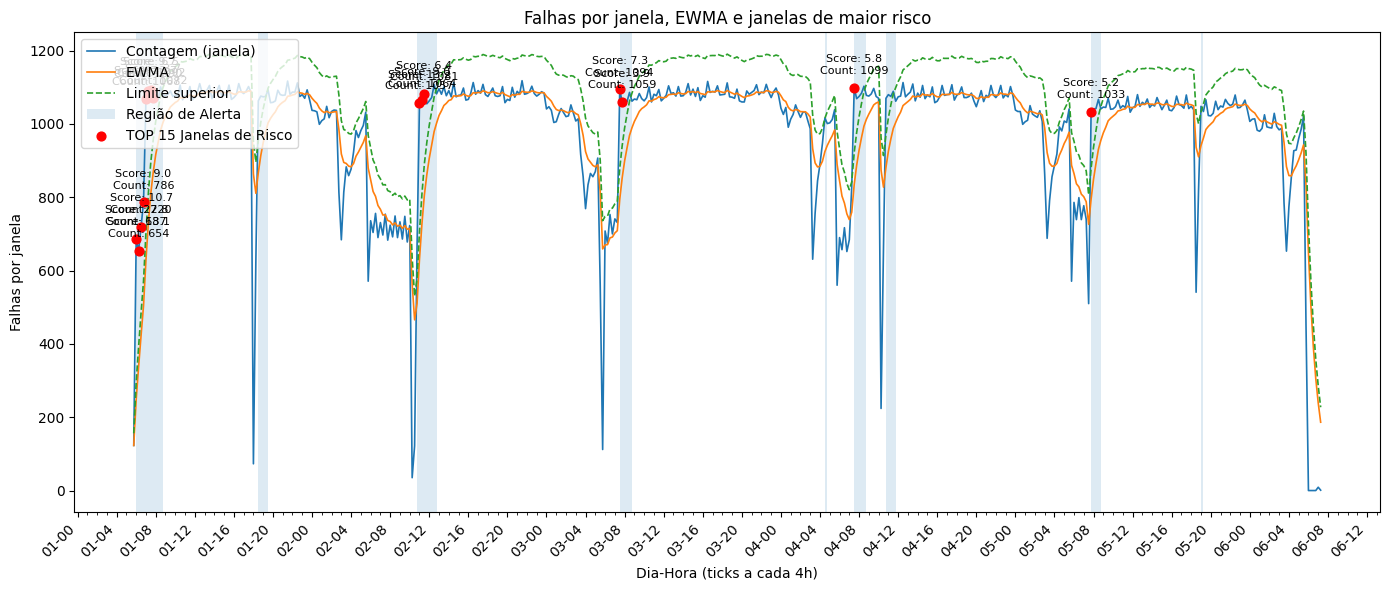

In [38]:
# -*- coding: utf-8 -*-
"""
plot_fail_windows.py
Gera gráfico com:
- contagem de falhas (por janela FREQ)
- EWMA e limite superior (lim_up)
- regiões de alerta (alert==1)
- TOP-N janelas com maior risk_score destacadas
- Eixo X formatado como DIA-HORA (%d-%H) com ticks a cada 4 horas
"""
import argparse
from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def parse_args():
    p = argparse.ArgumentParser(description="Plot de janelas com maior risco de falhas (EWMA + CUSUM)")
    p.add_argument("--indir", type=str, default="data")
    p.add_argument("--alerts", type=str, default="alerts_global.csv")
    p.add_argument("--risk", type=str, default="windows_at_risk.csv")
    p.add_argument("--out", type=str, default="data/failure_windows.png")
    p.add_argument("--top", type=int, default=15)
    a, _ = p.parse_known_args()
    return a


def _read_alerts_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    df = pd.read_csv(path)
    time_col = "ts" if "ts" in df.columns else ("Unnamed: 0" if "Unnamed: 0" in df.columns else df.columns[0])
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)
    for c in ("count", "ewma", "lim_up"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "alert" in df.columns:
        df["alert"] = df["alert"].fillna(0).astype(int)
    return df


def _read_risk_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    df = pd.read_csv(path)
    if "ts" not in df.columns:
        return pd.DataFrame()
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df = df.dropna(subset=["ts"]).sort_values(["risk_score", "count", "ts"], ascending=[False, False, False])
    return df


def _merge_spans_from_alert(alert_series: pd.Series, freq_minutes: int):
    s = alert_series.fillna(0).astype(int)
    if s.empty:
        return []
    spans, start, last = [], None, None
    for t, v in s.items():
        if v == 1 and start is None:
            start = last = t
        elif v == 1:
            last = t
        elif v == 0 and start is not None:
            spans.append((start, last + timedelta(minutes=freq_minutes)))
            start = last = None
    if start is not None:
        spans.append((start, last + timedelta(minutes=freq_minutes)))
    return spans


def main():
    args = parse_args()
    indir = Path(args.indir)
    alerts_csv = indir / args.alerts
    risk_csv = indir / args.risk
    out_png = Path(args.out)

    alerts = _read_alerts_csv(alerts_csv)
    if alerts.empty:
        raise SystemExit(f"{alerts_csv} está vazio ou ausente.")

    risk = _read_risk_csv(risk_csv)

    # Inferir frequência (minutos) a partir do índice temporal (apenas para sombrear corretamente)
    if len(alerts.index) > 1:
        freq_minutes = int(np.median(np.diff(alerts.index.values).astype("timedelta64[m]").astype(int)))
        freq_minutes = max(freq_minutes, 1)
    else:
        freq_minutes = 15

    # Figura
    fig, ax = plt.subplots(figsize=(14, 6))
    if "count" in alerts.columns:
        ax.plot(alerts.index, alerts["count"], label="Contagem (janela)", lw=1.2)
    if "ewma" in alerts.columns:
        ax.plot(alerts.index, alerts["ewma"], label="EWMA", lw=1.2)
    if "lim_up" in alerts.columns:
        ax.plot(alerts.index, alerts["lim_up"], label="Limite superior", lw=1.2, linestyle="--")

    # Sombreamento de alertas
    if "alert" in alerts.columns:
        for a, b in _merge_spans_from_alert(alerts["alert"], freq_minutes=freq_minutes):
            ax.axvspan(a, b, alpha=0.15, label="Região de Alerta")

    # Marcadores TOP-N por risco
    if not risk.empty and "ts" in risk.columns and "count" in alerts.columns:
        top = risk.head(max(1, int(args.top)))
        yvals = alerts["count"].reindex(top["ts"]).ffill().bfill()
        ax.scatter(top["ts"], yvals, s=40, marker="o", zorder=3, color='red', label=f'TOP {args.top} Janelas de Risco') # Added label and color

        # Add labels to the scatter points
        for i, row in top.iterrows():
            # Get the corresponding y-value from the alerts DataFrame
            y_val = alerts.loc[row['ts'], 'count'] if row['ts'] in alerts.index else None
            if y_val is not None:
                label = f"Score: {row['risk_score']:.1f}\nCount: {int(row['count'])}"
                ax.annotate(label, (row['ts'], y_val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)


    # ---- Eixo X: ticks a cada 4 horas e formatação DIA-HORA ----
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 4)))  # 0,4,8,12,16,20
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))
    # (opcional) minor ticks a cada 1h para referência visual
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

    fig.autofmt_xdate(rotation=45, ha="right")

    ax.set_title("Falhas por janela, EWMA e janelas de maior risco")
    ax.set_xlabel("Dia-Hora (ticks a cada 4h)")
    ax.set_ylabel("Falhas por janela")
    # Updated legend to handle duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper left")

    fig.tight_layout()

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=150)
    print(f"[OK] Gráfico salvo em: {out_png}")


if __name__ == "__main__":
    main()


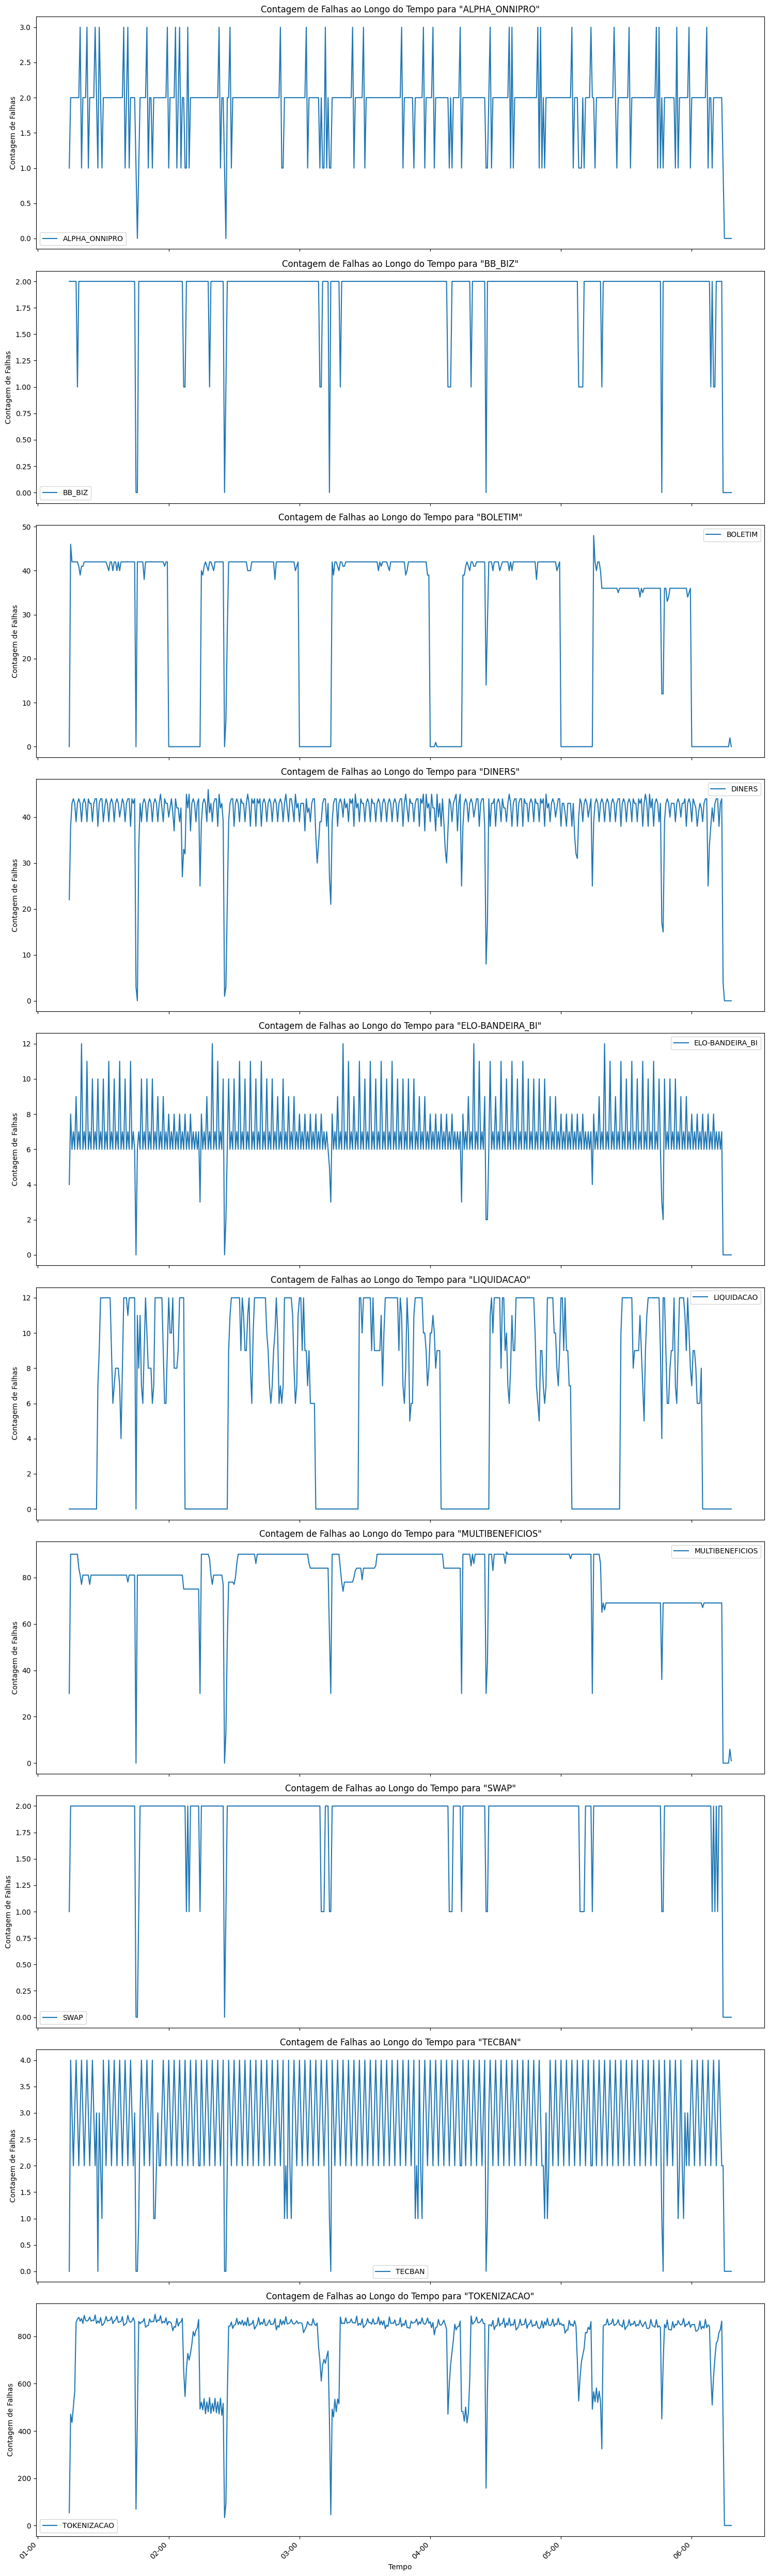

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import mdates for date formatting

# Set up the figure and axes for multiple subplots
fig, axes = plt.subplots(nrows=len(job_names), figsize=(15, 5 * len(job_names)))

# Flatten the axes array for easy iteration if there's more than one subplot
if len(job_names) > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Ensure axes is iterable even for a single job

# Iterate through each job and create a line plot with titles, labels, and legend
for i, job_name in enumerate(job_names):
    ax = axes[i]
    ax.plot(ts_by_job_df.index, ts_by_job_df[job_name], label=job_name)
    ax.set_title(f'Contagem de Falhas ao Longo do Tempo para "{job_name}"')
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Contagem de Falhas')
    ax.legend() # Add a legend to each subplot

    # Format the x-axis as DAY-HOUR
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))

# Apply date formatting to all axes after creating them
fig.autofmt_xdate(rotation=45, ha="right")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [42]:
# Aplicar EWMA e CUSUM para cada Job
job_alerts = {}
for job_name in ts_by_job_df.columns:
    # Get the time series for the current job
    job_series = ts_by_job_df[job_name]

    # Apply EWMA and CUSUM
    ewma_result = ewma_limits(job_series, span=config.span, z=config.z) # Assuming config is available from the consolidated cell
    cusum_result = cusum_pos(job_series, k=config.cusum_k, h=config.cusum_h) # Assuming config is available

    # Combine results
    alerts_df = pd.concat([ewma_result, cusum_result], axis=1)
    alerts_df["alert_ewma"] = alerts_df["alert_ewma"].fillna(False).astype(bool)
    alerts_df["alert_cusum"] = alerts_df["alert_cusum"].fillna(0).astype(int).astype(bool)
    alerts_df["alert"] = (alerts_df["alert_ewma"] | alerts_df["alert_cusum"]).astype(int)

    # Store the results
    job_alerts[job_name] = alerts_df

# Now job_alerts is a dictionary where keys are job names and values are DataFrames
# containing EWMA, CUSUM, and alert information for each job.

print("EWMA e CUSUM aplicados a cada Job. Resultados armazenados no dicionário 'job_alerts'.")
# You can inspect the results for a specific job, e.g.:
# display(job_alerts['NOME_DO_JOB'].head())

EWMA e CUSUM aplicados a cada Job. Resultados armazenados no dicionário 'job_alerts'.


In [43]:
# Example: Display alerts for the first job in the list
if job_names:
    first_job = job_names[0]
    print(f"\nAlerts for the first job ('{first_job}'):")
    display(job_alerts[first_job].head())


Alerts for the first job ('ALPHA_ONNIPRO'):


,count,ewma,lim_lo,lim_up,alert_ewma,risk_score,alert_cusum,alert
End Time,,,,,,,,
2025-09-01 05:45:00,1.0,1.000000,0.0,4.000000,False,0.0,False,0
2025-09-01 06:00:00,2.0,1.222222,0.0,4.538847,False,0.0,False,0
2025-09-01 06:15:00,2.0,1.395062,0.0,4.938444,False,0.0,False,0
2025-09-01 06:30:00,2.0,1.529492,0.0,5.239672,False,0.0,False,0
2025-09-01 06:45:00,2.0,1.634050,0.0,5.468948,False,0.0,False,0


In [46]:
# List the keys of the job_alerts dictionary
available_jobs = list(job_alerts.keys())

print("Jobs disponíveis no dicionário job_alerts:")
print(available_jobs)

Jobs disponíveis no dicionário job_alerts:
['ALPHA_ONNIPRO', 'BB_BIZ', 'BOLETIM', 'DINERS', 'ELO-BANDEIRA_BI', 'LIQUIDACAO', 'MULTIBENEFICIOS', 'SWAP', 'TECBAN', 'TOKENIZACAO']


## Gerar Gráfico de Alertas por Job

### Subtask:
Gerar um gráfico similar ao global, mas mostrando a série temporal de falhas, EWMA, limites e as regiões de alerta para um Job específico.

**Reasoning**:
Defina uma função que receba o nome do job e o dicionário `job_alerts` como entrada. Dentro da função, recupere o DataFrame de alertas do job especificado, verifique se está vazio e, em seguida, gere um gráfico semelhante ao de alertas global — incluindo contagem, EWMA, limites e regiões de alerta sombreadas — usando os dados específicos desse job.

In [44]:
from datetime import timedelta # Need timedelta for merging spans

def plot_job_alert_single(job_name: str, job_alerts_dict: dict, freq: str):
    """
    Gera e exibe o gráfico de alertas para um Job específico.

    Args:
        job_name: O nome do Job para plotar.
        job_alerts_dict: O dicionário contendo os DataFrames de alerta por Job.
        freq: A frequência temporal usada na análise (ex: '15min').
    """
    if job_name not in job_alerts_dict:
        print(f"[ERRO] Job '{job_name}' não encontrado no dicionário de alertas.")
        return

    alerts_df = job_alerts_dict[job_name]

    if alerts_df.empty:
        print(f"[WARN] DataFrame de alertas para o Job '{job_name}' está vazio. Não é possível gerar o gráfico.")
        return

    # Inferir FREQ (minutos) a partir da string de frequência
    # Assuming freq is in a format like '15min', '1h', etc.
    try:
        if freq.endswith('min'):
            freq_minutes = int(freq[:-3])
        elif freq.endswith('h'):
            freq_minutes = int(freq[:-1]) * 60
        # Add more frequency types if needed (e.g., 'D' for daily)
        else:
             # Attempt to infer from index if string parsing fails
            if len(alerts_df.index) > 1:
                 freq_minutes = int(np.median(np.diff(alerts_df.index.values).astype("timedelta64[m]").astype(int)))
                 freq_minutes = max(freq_minutes, 1)
            else:
                 freq_minutes = 15 # Default if inference also fails

    except ValueError:
         if len(alerts_df.index) > 1:
             freq_minutes = int(np.median(np.diff(alerts_df.index.values).astype("timedelta64[m]").astype(int)))
             freq_minutes = max(freq_minutes, 1)
         else:
             freq_minutes = 15


    fig, ax = plt.subplots(figsize=(14, 6))

    if "count" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["count"], label="Contagem (janela)", lw=1.2)
    if "ewma" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["ewma"], label="EWMA", lw=1.2)
    if "lim_up" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["lim_up"], label="Limite superior", lw=1.2, linestyle="--")

    # Sombrear blocos com alert==1
    if "alert" in alerts_df.columns:
        # Ensure alert is boolean for merging spans
        alert_series_bool = alerts_df["alert"].astype(bool)
        for a, b in _merge_spans_from_alert(alert_series_bool, freq_minutes=freq_minutes):
            # Check if the span is valid before plotting
            if pd.notnull(a) and pd.notnull(b) and a < b:
                ax.axvspan(a, b, alpha=0.15, color='red', label="Região de Alerta") # Using red for job-specific alerts


    ax.set_title(f"Alertas EWMA/CUSUM para o Job: \"{job_name}\"")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Falhas por janela")

    # Handle potential duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper left")

    # ---- Eixo X: ticks a cada 4 horas e formatação DIA-HORA ----
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 4)))  # 0,4,8,12,16,20
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))
    # (opcional) minor ticks a cada 1h para referência visual
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

    fig.autofmt_xdate(rotation=45, ha="right")

    fig.tight_layout()

    plt.show()

# Task
Crie um gráfico que demonstre os 10 Jobs mais ofensores em um gráfico de fácil leitura para um executivo, demonstrando os riscos do horário de execução a partir dos dados de execução dos Jobs.

## Preparar os dados

### Subtask:
Carregar os dados de execução dos Jobs (`df_runs`) e extrair a hora do dia do `End Time`.


**Reasoning**:
Check if `df_runs` is loaded, ensure 'End Time' is datetime, and extract the hour into a new column 'end_hour'.



In [47]:
# 1. Check if df_runs is loaded
if 'df_runs' not in locals() or df_runs is None or df_runs.empty:
    # Assuming config is available from the consolidated cell
    # If not, this would require re-parsing args or loading config
    try:
        # Use the config object created in the main execution block
        if 'cfg' in locals():
             df_runs = load_runs_many(cfg.csv_paths)
        else:
            # Fallback if config is not in locals() (e.g., running this cell first)
            # This might require re-implementing argument parsing or loading from a saved config
            print("[WARN] Config object not found. Attempting to load CSVs with default glob pattern.")
            default_csv_paths = _find_all_csv_by_pattern() # Assuming _find_all_csv_by_pattern is available
            if not default_csv_paths:
                 raise SystemExit("No CSVs found using the default pattern.")
            df_runs = load_runs_many(default_csv_paths)

        if df_runs.empty:
            raise SystemExit("No valid data loaded from CSVs.")
        print("df_runs loaded successfully.")

    except SystemExit as e:
        print(f"[ERROR] Failed to load df_runs: {e}")
        df_runs = pd.DataFrame() # Ensure df_runs is an empty DataFrame on failure

# Proceed only if df_runs is not empty
if not df_runs.empty:
    # 2. Ensure 'End Time' is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_runs['End Time']):
        print("Converting 'End Time' to datetime.")
        df_runs['End Time'] = pd.to_datetime(df_runs['End Time'], errors='coerce')
        # Drop rows where conversion failed
        df_runs = df_runs.dropna(subset=['End Time']).reset_index(drop=True)
        if df_runs.empty:
            print("[ERROR] No valid 'End Time' entries after conversion. Cannot proceed.")
    else:
        print("'End Time' is already datetime.")


    # 3. Create 'end_hour' column
    if not df_runs.empty:
        df_runs['end_hour'] = df_runs['End Time'].dt.hour
        print("Created 'end_hour' column.")
        display(df_runs.head())
    else:
        print("df_runs is empty after cleaning. Cannot create 'end_hour'.")

else:
    print("df_runs is empty. Skipping hour extraction.")


'End Time' is already datetime.
Created 'end_hour' column.


,Job,Application,Sub-Application,Folder,Host,Ended Status,Start Time,End Time,Creation Date,status,duration_s,__source_csv__,end_hour
0,DINERS,ELO-DETOKENIZACAO_LIQUIDACAO_CREDENCIADOR_DINERS,DINERS,ELO-PRD,"tags: ""srvpconnect01.elo.corp:prodcdctm""",fail,2025-09-01 05:51:00,2025-09-01 05:52:02,01/09/25,1,62.0,data/Relatorio-ELOPRD-010925-160925_2025-09-01...,5
1,DINERS,ELO-DETOKENIZACAO_LIQUIDACAO_CREDENCIADOR_DINERS,DINERS,ELO-PRD,"tags: ""srvpconnect01.elo.corp:prodcdctm""",fail,2025-09-01 05:51:00,2025-09-01 05:52:02,01/09/25,1,62.0,data/Relatorio-ELOPRD-010925-160925_2025-09-01...,5
2,DINERS,ELO-DETOKENIZACAO_LIQUIDACAO_CREDENCIADOR_DINERS,DINERS,ELO-PRD,"tags: ""srvpconnect01.elo.corp:prodcdctm""",fail,2025-09-01 05:51:00,2025-09-01 05:53:03,01/09/25,1,123.0,data/Relatorio-ELOPRD-010925-160925_2025-09-01...,5
3,DINERS,ELO-DETOKENIZACAO_LIQUIDACAO_CREDENCIADOR_DINERS,DINERS,ELO-PRD,"tags: ""srvpconnect01.elo.corp:prodcdctm""",fail,2025-09-01 05:51:00,2025-09-01 05:53:03,01/09/25,1,123.0,data/Relatorio-ELOPRD-010925-160925_2025-09-01...,5
4,DINERS,ELO-DETOKENIZACAO_LIQUIDACAO_CREDENCIADOR_DINERS,DINERS,ELO-PRD,"tags: ""srvpconnect01.elo.corp:prodcdctm""",fail,2025-09-01 05:52:00,2025-09-01 05:54:03,01/09/25,1,123.0,data/Relatorio-ELOPRD-010925-160925_2025-09-01...,5


## Calcular falhas por job e hora

### Subtask:
Agrupar os dados por Job e hora do dia e contar o número de falhas em cada grupo.


**Reasoning**:
Group the filtered DataFrame by 'Job' and 'end_hour' and count the number of failures, then convert the result to a DataFrame and rename the count column.



In [48]:
# 1. Ensure df_runs is not empty (already checked in the previous step, but good for robustness)
if not df_runs.empty:
    # 2. Filter for failed jobs
    failed_jobs_df = df_runs[df_runs['status'] == 1].copy()

    if not failed_jobs_df.empty:
        # 3. Group by 'Job' and 'end_hour' and count
        failures_by_job_hour = failed_jobs_df.groupby(['Job', 'end_hour']).size()

        # 4. Convert the result to a DataFrame and rename the count column
        failures_by_job_hour = failures_by_job_hour.reset_index(name='failure_count')

        print("Failures counted by Job and hour of day.")
        display(failures_by_job_hour.head())
    else:
        print("No failed jobs found in df_runs. Cannot proceed with grouping.")
        failures_by_job_hour = pd.DataFrame(columns=['Job', 'end_hour', 'failure_count']) # Ensure the variable is defined as an empty DataFrame

else:
    print("df_runs is empty. Cannot group by Job and hour.")
    failures_by_job_hour = pd.DataFrame(columns=['Job', 'end_hour', 'failure_count']) # Ensure the variable is defined as an empty DataFrame

Failures counted by Job and hour of day.


,Job,end_hour,failure_count
0,ADYEN,0,40
1,ADYEN,1,40
2,ADYEN,2,40
3,ADYEN,3,35
4,ADYEN,4,33


## Identificar os top jobs ofensores

### Subtask:
Determinar os 10 Jobs com o maior número total de falhas ou maior risco agregado (podemos usar a contagem de falhas como proxy de ofensa para este gráfico executivo).


**Reasoning**:
Group the failures by Job, sum the counts, sort, and select the top 10.



In [49]:
# 1. Ensure the failures_by_job_hour DataFrame is not empty
if not failures_by_job_hour.empty:
    # 2. Group by 'Job' and calculate the total 'failure_count'
    total_failures_by_job = failures_by_job_hour.groupby('Job')['failure_count'].sum()

    # 3. Sort the Jobs by total failure count in descending order
    top_offending_jobs = total_failures_by_job.sort_values(ascending=False)

    # 4. Select the top 10 Jobs
    top_10_jobs = top_offending_jobs.head(10)

    # 5. Store the names of the top 10 Jobs
    top_10_job_names = top_10_jobs.index.tolist()

    print("Top 10 most offending jobs based on total failure count:")
    display(top_10_jobs)
    print("\nList of top 10 job names:")
    print(top_10_job_names)

else:
    print("failures_by_job_hour DataFrame is empty. Cannot determine top offending jobs.")
    top_10_job_names = [] # Ensure the list is defined even if empty

Top 10 most offending jobs based on total failure count:


,failure_count
Job,
TOKENIZACAO,383242
MULTIBENEFICIOS,39089
DINERS,19673
BOLETIM,14397
ELO-BANDEIRA_BI,3365
LIQUIDACAO,3064
TECBAN,1374
ALPHA_ONNIPRO,931
BB_BIZ,928



List of top 10 job names:
['TOKENIZACAO', 'MULTIBENEFICIOS', 'DINERS', 'BOLETIM', 'ELO-BANDEIRA_BI', 'LIQUIDACAO', 'TECBAN', 'ALPHA_ONNIPRO', 'BB_BIZ', 'BIZ']


## Criar uma matriz de falhas (job vs hora)

### Subtask:
Pivotar os dados agregados para ter os Jobs como linhas, as horas do dia como colunas e a contagem de falhas como valores.


**Reasoning**:
Filter the failures_by_job_hour dataframe, pivot it to have jobs as rows and hours as columns, fill missing values with 0, and sort the columns.



In [50]:
# 1. Ensure the failures_by_job_hour DataFrame is not empty
if failures_by_job_hour.empty:
    print("[WARN] failures_by_job_hour DataFrame is empty. Cannot proceed with pivoting.")
    top_jobs_pivot = pd.DataFrame() # Ensure the variable is defined
else:
    # 2. Ensure the list of top 10 job names is not empty
    if not top_10_job_names:
        print("[WARN] top_10_job_names list is empty. Cannot filter failures_by_job_hour.")
        top_jobs_pivot = pd.DataFrame() # Ensure the variable is defined
    else:
        # 3. Filter failures_by_job_hour to include only the top 10 jobs
        filtered_failures = failures_by_job_hour[failures_by_job_hour['Job'].isin(top_10_job_names)].copy()

        if filtered_failures.empty:
            print("[WARN] Filtered DataFrame for top 10 jobs is empty. Cannot pivot.")
            top_jobs_pivot = pd.DataFrame() # Ensure the variable is defined
        else:
            # 4. Pivot the filtered DataFrame
            top_jobs_pivot = filtered_failures.pivot(index='Job', columns='end_hour', values='failure_count')

            # 5. Fill any missing values with 0
            top_jobs_pivot = top_jobs_pivot.fillna(0)

            # 6. Sort the columns (hours) in ascending order
            top_jobs_pivot = top_jobs_pivot.sort_index(axis=1)

            print("Pivoted DataFrame for top 10 jobs created.")
            display(top_jobs_pivot.head())


Pivoted DataFrame for top 10 jobs created.


end_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Job,,,,,,,,,,,,,,,,,,,,,
ALPHA_ONNIPRO,39.0,40.0,41.0,31.0,37.0,38.0,39.0,41.0,39.0,42.0,...,40.0,41.0,39.0,40.0,36.0,40.0,39.0,35.0,41.0,40.0
BB_BIZ,40.0,40.0,39.0,31.0,36.0,38.0,40.0,35.0,40.0,40.0,...,40.0,40.0,40.0,40.0,34.0,40.0,40.0,40.0,40.0,40.0
BIZ,39.0,42.0,37.0,33.0,36.0,40.0,37.0,35.0,39.0,41.0,...,39.0,41.0,38.0,44.0,34.0,38.0,40.0,40.0,40.0,40.0
BOLETIM,0.0,1.0,0.0,0.0,0.0,0.0,832.0,815.0,807.0,816.0,...,804.0,808.0,813.0,816.0,726.0,794.0,816.0,816.0,816.0,800.0
DINERS,836.0,825.0,784.0,754.0,847.0,732.0,844.0,844.0,847.0,845.0,...,848.0,845.0,846.0,842.0,701.0,844.0,846.0,845.0,847.0,843.0


## Gerar o gráfico

### Subtask:
Criar um gráfico visualmente intuitivo (como um heatmap ou barras agrupadas) que mostre a matriz de falhas, destacando os horários de maior risco para os top Jobs.


**Reasoning**:
Generate a heatmap using the pivoted failure data to visualize failure counts by job and hour, highlighting high-risk periods.



[INFO] Running in notebook environment. Using default config paths and args.
--- Iniciando Pipeline de Monitoramento de Falhas (Consolidado) ---
Configuração: Config(csv_paths=['data/Relatorio-ELOPRD-010925-160925_2025-09-01.csv', 'data/Relatorio-ELOPRD-010925-160925_2025-09-02.csv', 'data/Relatorio-ELOPRD-010925-160925_2025-09-03.csv', 'data/Relatorio-ELOPRD-010925-160925_2025-09-04.csv', 'data/Relatorio-ELOPRD-010925-160925_2025-09-05.csv'], outdir=PosixPath('data'), scripts_dir=PosixPath('scripts'), models_dir=PosixPath('models'), freq='15min', span=8, z=3.0, cusum_k=0.5, cusum_h=5.0, top_jobs=10, exec_heatmap_top_n=10)

--- Carregando dados ---
Dados carregados: 511617 linhas.

--- Gerando séries temporais ---

--- Calculando EWMA e CUSUM Global ---
Alertas globais calculados: 43 janelas com alerta.
Série global: 487 pontos.
Série por Job: 487 pontos x 10 Jobs.

--- Gerando features por Job ---
Features por Job geradas: 17080 linhas.

--- Salvando dados processados ---
[OK] Salvo: 

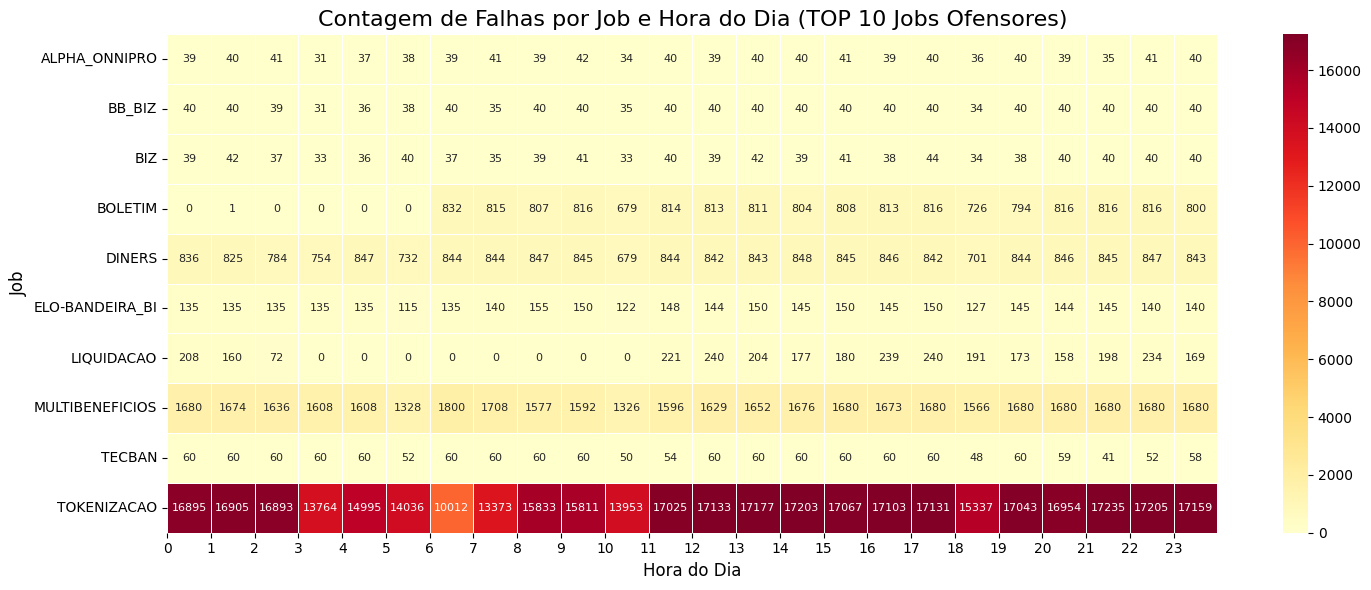

In [54]:
# -*- coding: utf-8 -*-
"""
Consolidated Pipeline Script

Combines data loading, processing, global and job-specific anomaly detection (EWMA + CUSUM),
and plotting logic from base.py and plot_fail_windows.py into a single cell.
Includes executive heatmap.
"""
import argparse
import json
from dataclasses import dataclass
from glob import glob
from pathlib import Path
from typing import Iterable, Tuple, List, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import mdates for date formatting
import seaborn as sns # Import seaborn for heatmap


# =========================
# Config e parsing de args (Adaptado de base.py)
# =========================
@dataclass
class Config:
    csv_paths: List[str]   # múltiplos CSVs
    outdir: Path           # ./data
    scripts_dir: Path      # ./scripts (mantido para consistência nos paths de saída, mas scripts não serão gerados aqui)
    models_dir: Path       # ./models
    freq: str
    span: int
    z: float
    cusum_k: float
    cusum_h: float
    top_jobs: int
    exec_heatmap_top_n: int # Added arg for executive heatmap top N


DEFAULT_GLOB = "data/Relatorio*.csv"  # <- somente arquivos iniciando com 'Relatorio'


def _find_all_csv_by_pattern(pattern: str = DEFAULT_GLOB) -> List[str]:
    return sorted(glob(pattern))


def _normalize_csv_args(csv_args: Sequence[str] | None, csv_glob: str | None) -> List[str]:
    paths: List[str] = []
    # --csv pode vir repetido e/ou com vírgulas
    if csv_args:
        for item in csv_args:
            parts = [p.strip() for p in item.split(",") if p.strip()]
            paths.extend(parts)
    # --csv-glob (se não vier, usamos o DEFAULT_GLOB)
    if csv_glob:
        paths.extend(glob(csv_glob))
    if not csv_args and not csv_glob:
        # padrão: somente 'Relatorio*.csv' no diretório data/
        paths = _find_all_csv_by_pattern(DEFAULT_GLOB)

    # Filtra existentes e remove duplicados preservando ordem
    seen = set()
    clean = []
    for p in paths:
        if not Path(p).exists():
            continue
        if p not in seen:
            clean.append(p)
            seen.add(p)
    return clean


def parse_args(argv=None) -> Config:
    # Usamos o parser do base.py, mas adaptamos a descrição
    p = argparse.ArgumentParser(description="Análise temporal de falhas em JOBs (EWMA + CUSUM) com múltiplos CSVs e geração de relatórios/gráficos.")
    p.add_argument("--csv", dest="csv_paths", action="append", required=False,
                   help="Caminho(s) CSV. Pode repetir a flag ou passar lista separada por vírgulas.")
    p.add_argument("--csv-glob", type=str, default=None,
                   help=f"Padrão glob (default implícito: '{DEFAULT_GLOB}').")
    p.add_argument("--outdir", type=str, default="data", help="Diretório de saída (default: data)")
    p.add_argument("--scripts-dir", type=str, default="scripts", help="Diretório para scripts (default: scripts)") # Not used for output here
    p.add_argument("--models-dir", type=str, default="models", help="Diretório para modelos (default: models)")
    p.add_argument("--freq", type=str, default="15min", help="Frequência (ex.: 5min, 15min, 1h)")
    p.add_argument("--span", type=int, default=8, help="Span do EWMA (default: 8)")
    p.add_argument("--z", type=float, default=3.0, help="Multiplicador de sigma (default: 3.0)")
    p.add_argument("--cusum-k", type=float, default=0.5, help="Parâmetro k do CUSUM (default: 0.5)")
    p.add_argument("--cusum-h", type=float, default=5.0, help="Limiar h do CUSUM (default: 5.0)")
    p.add_argument("--top-jobs", type=int, default=10, help="N de jobs em ts_by_job (default: 10)")
    p.add_argument("--exec-heatmap-top-n", type=int, default=10, help="N de jobs para o heatmap executivo (default: 10)")


    # Ignora args do kernel (-f ...) quando em Jupyter/Colab
    a, unknown = p.parse_known_args(argv)
    try:
        from IPython import get_ipython
        in_notebook = get_ipython() is not None
    except Exception:
        in_notebook = False
    if unknown and not in_notebook:
        print(f"[WARN] Ignorando argumentos desconhecidos: {unknown}")

    csv_paths = _normalize_csv_args(a.csv_paths, a.csv_glob)
    if not csv_paths:
        raise SystemExit(f"Nenhum CSV encontrado. Coloque arquivos que iniciem com 'Relatorio' em ./data "
                         f"ou use --csv / --csv-glob.")

    return Config(
        csv_paths=csv_paths,
        outdir=Path(a.outdir),
        scripts_dir=Path(a.scripts_dir), # Still in config, but not used for saving scripts here
        models_dir=Path(a.models_dir),
        freq=a.freq,
        span=a.span,
        z=a.z,
        cusum_k=a.cusum_k,
        cusum_h=a.cusum_h,
        top_jobs=a.top_jobs,
        exec_heatmap_top_n=a.exec_heatmap_top_n,
    )


# ===========
# Utilidades (Copiadas de base.py)
# ===========
def _clean_cols(cols: Iterable[str]) -> List[str]:
    return [str(c).replace("\ufeff", "").strip() for c in cols]


# =======================
# 1) Leitura e limpeza (Copiadas de base.py)
# =======================
REQUIRED_COLS = {"Ended Status", "Start Time", "End Time", "Job"}

def _load_one_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, sep=None, engine="python")
    df.columns = _clean_cols(df.columns)

    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        print(f"[WARN] {csv_path}: colunas ausentes {missing} — arquivo ignorado.")
        return pd.DataFrame(columns=list(REQUIRED_COLS))

    df["Ended Status"] = df["Ended Status"].astype(str).str.lower().str.strip()
    df["status"] = df["Ended Status"].map({"fail": 1, "succeed": 0})

    # Datas (ajuste o formato caso necessário)
    df["Start Time"] = pd.to_datetime(df["Start Time"], format="%d/%m/%y %H:%M:%S", errors="coerce")
    df["End Time"]   = pd.to_datetime(df["End Time"],   format="%d/%m/%y %H:%M:%S", errors="coerce")

    df = df.dropna(subset=["End Time"])
    df["duration_s"] = (df["End Time"] - df["Start Time"]).dt.total_seconds()
    df["duration_s"] = df["duration_s"].fillna(0).clip(lower=0)

    df["Job"] = df["Job"].astype(str).str.strip()
    df["__source_csv__"] = csv_path
    return df


def load_runs_many(csv_paths: Sequence[str]) -> pd.DataFrame:
    frames = []
    for p in csv_paths:
        try:
            df = _load_one_csv(p)
            if not df.empty:
                frames.append(df)
        except Exception as e:
            print(f"[WARN] Falha ao ler {p}: {e}")
    if not frames:
        return pd.DataFrame(columns=list(REQUIRED_COLS))
    df_all = pd.concat(frames, ignore_index=True)
    # ordena por End Time para robustez
    if "End Time" in df_all.columns:
        df_all = df_all.sort_values("End Time").reset_index(drop=True)
    return df_all


# ======================
# 2) Séries temporais (Copiadas de base.py)
# ======================
def failures_global(df: pd.DataFrame, freq: str) -> pd.Series:
    """Contagem de falhas por janela temporal (freq)."""
    freq = freq.lower()
    fail_mask = df["status"] == 1
    ts = (
        df.loc[fail_mask]
        .set_index("End Time")
        .assign(cnt=1)
        .resample(freq)["cnt"]
        .sum()
        .fillna(0.0)
        .astype(float)
    )
    return ts


def failures_by_top_jobs(df: pd.DataFrame, freq: str, top_jobs: int) -> pd.DataFrame:
    """Matriz (tempo x job) com contagem de falhas para os TOP-N jobs por frequência de falha."""
    freq = freq.lower()
    fail_mask = df["status"] == 1
    top = df.loc[fail_mask, "Job"].value_counts().head(top_jobs).index.tolist()
    if not top:
        return pd.DataFrame()
    mat = (
        df.loc[fail_mask & df["Job"].isin(top)]
        .set_index("End Time")
        .groupby("Job")
        .resample(freq)["Ended Status"]
        .count()
        .unstack(0)
        .fillna(0.0)
        .sort_index()
        .astype(float)
    )
    return mat


# ===========================
# 3) EWMA + Limites + CUSUM (Copiadas de base.py)
# ===========================
def ewma_limits(counts: pd.Series, span: int = 8, z: float = 3.0) -> pd.DataFrame:
    """
    EWMA da contagem; limites baseados em var ≈ mean (Poisson-like).
    risk_score: excesso acima de lim_up, normalizado (proxy de severidade).
    """
    s = counts.astype(float).copy()
    ew = s.ewm(span=span, adjust=False).mean()
    sigma = np.sqrt(np.maximum(ew, 1.0))  # sd ~ sqrt(lambda)
    lim_up = ew + z * sigma
    lim_lo = np.maximum(ew - z * sigma, 0.0)

    out = pd.DataFrame({"count": s, "ewma": ew, "lim_lo": lim_lo, "lim_up": lim_up})

    alert_ewma = (out["count"] > out["lim_up"]).astype(bool)
    above = (out["count"] - out["lim_up"]).clip(lower=0.0)
    denom = np.sqrt(out["lim_up"].replace(0.0, 1.0))
    risk_score = (above / denom).fillna(0.0)

    out["alert_ewma"] = alert_ewma
    out["risk_score"] = risk_score
    return out


def cusum_pos(counts: pd.Series, k: float = 0.5, h: float = 5.0) -> pd.Series:
    """
    CUSUM (lado positivo) -> Série int (0/1) com mesmo índice de 'counts'.
    """
    x = counts.astype(float).values
    mu = float(np.mean(x))
    sd = float(np.std(x)) + 1e-9
    s = (x - mu) / sd
    g = np.zeros_like(s)
    alarms = np.zeros_like(s, dtype=int)
    for i in range(1, len(s)):
        g[i] = max(0.0, g[i - 1] + s[i] - k)
        if g[i] > h:
            alarms[i] = 1
            g[i] = 0.0  # reset opcional
    return pd.Series(alarms, index=counts.index, name="alert_cusum")


# ==========================================
# 4) Features em janelas (para modelagem) (Copiadas de base.py)
# ==========================================
def make_rolling_features(
    df_runs: pd.DataFrame,
    group_cols: Tuple[str, ...] = ("Job",),
    freq: str = "15min",
    windows: Tuple[str, ...] = ("15min", "30min", "1h", "3h"),
) -> pd.DataFrame:
    """
    Para cada grupo (ex.: Job), gera contagens de falhas por janela e
    soma móvel em múltiplas janelas + tempo desde a última falha (min).
    """
    # Normaliza
    freq = freq.lower()
    windows = tuple(w.lower() for w in windows)

    d = (
        df_runs.assign(flag=df_runs["status"].astype(int))
        .set_index("End Time")
        .sort_index()
    )
    if d.index.size == 0:
        return pd.DataFrame()

    idx = pd.date_range(d.index.min().floor(freq), d.index.max().ceil(freq), freq=freq)
    feats = []
    for keys, g in d.groupby(list(group_cols)):
        s = (
            g[g["status"] == 1]
            .assign(cnt=1)["cnt"]
            .resample(freq)
            .sum()
            .reindex(idx)
            .fillna(0.0)
        )
        df_feat = pd.DataFrame(index=idx)
        keys_tuple = keys if isinstance(keys, tuple) else (keys,)
        for name, val in zip(group_cols, keys_tuple):
            df_feat[name] = val
        df_feat["cnt"] = s.astype(float)

        for w in windows:
            df_feat[f"cnt_{w}"] = s.rolling(w, min_periods=1).sum().astype(float)

        last_idx = None
        ttl = []
        for t, v in s.items():
            if v > 0:
                last_idx = t
                ttl.append(0.0)
            else:
                ttl.append(((t - last_idx).total_seconds() / 60.0) if last_idx else np.nan)
        df_feat["mins_since_last_fail"] = ttl

        feats.append(df_feat.reset_index(names="ts"))
    out = pd.concat(feats, ignore_index=True) if feats else pd.DataFrame()
    return out


# =======================
# Plotting Helpers (Copiadas de plot_fail_windows.py)
# =======================
from datetime import timedelta # Need timedelta for merging spans

def _read_alerts_csv(path: Path) -> pd.DataFrame:
    """
    Lê alerts_global.csv salvo pelo base.py e devolve um DataFrame indexado por timestamp.
    Suporta:
      - índice salvo como 'Unnamed: 0' (padrão pandas)
      - coluna explícita 'ts'
    """
    if not path.exists():
        return pd.DataFrame()

    df = pd.read_csv(path)

    # Detecta coluna temporal
    if "ts" in df.columns:
        time_col = "ts"
    elif "Unnamed: 0" in df.columns:
        time_col = "Unnamed: 0"
    else:
        time_col = df.columns[0]

    # Parse e index
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)

    # Tipos esperados
    for c in ("count", "ewma", "lim_up"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "alert" in df.columns:
        df["alert"] = df["alert"].fillna(0).astype(int)

    return df


def _read_risk_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    df = pd.read_csv(path)
    if "ts" not in df.columns:
        return pd.DataFrame()
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df = df.dropna(subset=["ts"]).sort_values(["risk_score", "count", "ts"], ascending=[False, False, False])
    return df


def _merge_spans_from_alert(alert_series: pd.Series, freq_minutes: int):
    """Constrói blocos contínuos (spans) onde alert==1 para sombrear no gráfico."""
    s = alert_series.fillna(0).astype(int)
    if s.empty:
        return []
    spans = []
    start = None
    last = None
    for t, v in s.items():
        if v == 1 and start is None:
            start = t; last = t
        elif v == 1:
            last = t
        elif v == 0 and start is not None:
            spans.append((start, last + timedelta(minutes=freq_minutes)))
            start = None; last = None
    if start is not None:
        spans.append((start, last + timedelta(minutes=freq_minutes)))
    return spans


# =======================
# Plotting Functions (Copiadas e Adaptadas)
# =======================

# Adapted plot_global_alerts to accept DataFrames directly
def plot_global_alerts(alerts_df: pd.DataFrame, risk_df: pd.DataFrame, output_path: Path, top_n: int = 15):
    """
    Gera e salva o gráfico global de alertas.

    Args:
        alerts_df: DataFrame com dados de alerta global.
        risk_df: DataFrame com ranking de risco global.
        output_path: Caminho para salvar o gráfico PNG.
        top_n: Número de janelas de maior risco para destacar.
    """
    if alerts_df.empty:
        print(f"[WARN] DataFrame de alertas global vazio. Não foi possível gerar o gráfico global.")
        return

    # Inferir FREQ (minutos) a partir do índice temporal
    if len(alerts_df.index) > 1:
        freq_minutes = int(np.median(np.diff(alerts_df.index.values).astype("timedelta64[m]").astype(int)))
        freq_minutes = max(freq_minutes, 1)
    else:
        freq_minutes = 15 # Default if only one data point

    # Figura
    fig, ax = plt.subplots(figsize=(14, 6))
    if "count" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["count"], label="Contagem (janela)", lw=1.2)
    if "ewma" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["ewma"], label="EWMA", lw=1.2)
    if "lim_up" in alerts_df.columns:
        ax.plot(alerts_df.index, alerts_df["lim_up"], label="Limite superior", lw=1.2, linestyle="--")

    # Sombrear blocos com alert==1
    if "alert" in alerts_df.columns:
        # Ensure alert is boolean for merging spans
        alert_series_bool = alerts_df["alert"].astype(bool)
        for a, b in _merge_spans_from_alert(alert_series_bool, freq_minutes=freq_minutes):
             # Check if the span is valid before plotting
            if pd.notnull(a) and pd.notnull(b) and a < b:
                ax.axvspan(a, b, alpha=0.15, color='gray', label="Região de Alerta") # Added color and label


    # Destacar TOP-N janelas por risco (se existir risk_df e 'ts'/'count' col)
    if not risk_df.empty and "ts" in risk_df.columns and "count" in alerts_df.columns:
        top = risk_df.head(max(1, int(top_n)))
        # Sem FutureWarning: usar ffill()/bfill() no lugar de fillna(method=...)
        # Ensure 'ts' in top DataFrame are valid datetime objects before reindexing
        top = top.dropna(subset=['ts'])
        if not top.empty:
            # Use .loc for label-based indexing which is appropriate for datetime index
            # Ensure the index exists in alerts_df before accessing
            valid_ts = top['ts'][top['ts'].isin(alerts_df.index)]
            if not valid_ts.empty:
                 yvals = alerts_df["count"].loc[valid_ts].ffill().bfill()
                 ax.scatter(valid_ts, yvals, s=40, marker="o", zorder=3, color='red', label=f'TOP {top_n} Janelas de Risco') # Added label and color

                 # Add labels to the scatter points for valid timestamps
                 for i, row in top[top['ts'].isin(alerts_df.index)].iterrows():
                      y_val = alerts_df.loc[row['ts'], 'count']
                      label = f"Score: {row['risk_score']:.1f}\nCount: {int(row['count'])}"
                      ax.annotate(label, (row['ts'], y_val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)


    plt.title("Falhas por janela, EWMA e janelas de maior risco")
    plt.xlabel("Tempo")
    plt.ylabel("Falhas por janela")

    # Handle potential duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper left")


    # ---- Eixo X: ticks a cada 4 horas e formatação DIA-HORA ----
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 4)))  # 0,4,8,12,16,20
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))
    # (opcional) minor ticks a cada 1h para referência visual
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

    fig.autofmt_xdate(rotation=45, ha="right")

    fig.tight_layout()

    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=150)
    print(f"[OK] Gráfico global salvo em: {output_path}")
    plt.close(fig) # Close the figure to free memory


# Function to plot job-specific failures (Adapted from notebook code)
def plot_job_failures(ts_by_job_df: pd.DataFrame, output_path: Path):
    """
    Gera e salva gráficos de linha para a contagem de falhas de cada Job ao longo do tempo.

    Args:
        ts_by_job_df: DataFrame com séries temporais de falhas por Job.
        output_path: Caminho para salvar o gráfico PNG (será um único arquivo com múltiplos subplots).
    """
    if ts_by_job_df.empty:
        print("[WARN] DataFrame de séries temporais por Job vazio. Não foi possível gerar gráficos por Job.")
        return

    job_names = ts_by_job_df.columns.tolist()
    n_jobs = len(job_names)

    # Set up the figure and axes for multiple subplots
    # Ajuste o figsize para que os plots não fiquem muito pequenos se houver muitos jobs
    rows = int(np.ceil(n_jobs / 2)) # 2 colunas de plots
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, 5 * rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through each job and create a line plot with titles, labels, and legend
    for i, job_name in enumerate(job_names):
        ax = axes[i]
        # Use ts_by_job diretamente, pois já está carregado
        ax.plot(ts_by_job_df.index, ts_by_job_df[job_name], label=job_name)
        ax.set_title(f'Falhas ao Longo do Tempo: "{job_name}"')
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Contagem de Falhas')
        ax.legend()

        # Format the x-axis as DAY-HOUR
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 4)))  # 0,4,8,12,16,20
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))

    # Hide any unused subplots if n_jobs is odd
    if n_jobs < len(axes):
        for j in range(n_jobs, len(axes)):
            fig.delaxes(axes[j])


    # Apply date formatting to all axes after creating them
    fig.autofmt_xdate(rotation=45, ha="right")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=150)
    print(f"[OK] Gráfico por Job salvo em: {output_path}")
    plt.close(fig) # Close the figure to free memory


# Function to generate executive heatmap (New function based on notebook code)
def generate_executive_heatmap(df_runs: pd.DataFrame, top_n: int = 10, output_path: Path = Path("data/heatmap_job_hour_risk_executive.png")):
    """
    Gera e salva um heatmap mostrando a contagem de falhas por Job e hora do dia
    para os TOP N Jobs mais ofensores.

    Args:
        df_runs: DataFrame com os dados de execução dos Jobs.
        top_n: Número de Jobs mais ofensores para incluir no heatmap.
        output_path: Caminho para salvar o heatmap PNG.
    """
    print("\n--- Gerando Heatmap Executivo ---")

    if df_runs.empty:
        print("[WARN] DataFrame de dados de execução vazio. Não foi possível gerar o heatmap executivo.")
        return

    # 1. Extrair hora do dia
    # Ensure 'End Time' is datetime (already done in main pipeline, but good to be safe)
    if not pd.api.types.is_datetime64_any_dtype(df_runs['End Time']):
        df_runs['End Time'] = pd.to_datetime(df_runs['End Time'], errors='coerce')
        df_runs = df_runs.dropna(subset=['End Time']).reset_index(drop=True) # Drop rows where conversion failed
        if df_runs.empty:
            print("[WARN] No valid 'End Time' entries after conversion. Cannot create heatmap.")
            return

    df_runs['end_hour'] = df_runs['End Time'].dt.hour

    # 2. Filtrar por falhas
    failed_jobs_df = df_runs[df_runs['status'] == 1].copy()

    if failed_jobs_df.empty:
        print("[WARN] Nenhum Job falhou nos dados. Não foi possível gerar o heatmap executivo.")
        # Generate empty output file
        output_path.parent.mkdir(parents=True, exist_ok=True)
        (output_path).write_text("", encoding="utf-8")
        print(f"[INFO] Heatmap executivo salvo como vazio: {output_path}")
        return


    # 3. Calcular falhas por Job e hora
    failures_by_job_hour = failed_jobs_df.groupby(['Job', 'end_hour']).size().reset_index(name='failure_count')

    # 4. Identificar os top N Jobs ofensores (baseado na contagem total)
    total_failures_by_job = failures_by_job_hour.groupby('Job')['failure_count'].sum()
    top_offending_jobs = total_failures_by_job.sort_values(ascending=False)
    top_n_job_names = top_offending_jobs.head(max(1, int(top_n))).index.tolist() # Ensure top_n is at least 1


    if not top_n_job_names:
        print("[WARN] Não foi possível identificar Jobs ofensores para o heatmap executivo.")
        # Generate empty output file
        output_path.parent.mkdir(parents=True, exist_ok=True)
        (output_path).write_text("", encoding="utf-8")
        print(f"[INFO] Heatmap executivo salvo como vazio: {output_path}")
        return

    # 5. Criar uma matriz de falhas (Job vs Hora) para os top N Jobs
    filtered_failures = failures_by_job_hour[failures_by_job_hour['Job'].isin(top_n_job_names)].copy()
    top_jobs_pivot = filtered_failures.pivot(index='Job', columns='end_hour', values='failure_count')

    # Fill any missing values with 0 and convert to integer for heatmap annotation
    top_jobs_pivot_int = top_jobs_pivot.fillna(0).astype(int)

    # Ensure all 24 hours are columns, fill missing hours with 0
    all_hours = range(24)
    for hour in all_hours:
        if hour not in top_jobs_pivot_int.columns:
            top_jobs_pivot_int[hour] = 0
    top_jobs_pivot_int = top_jobs_pivot_int.sort_index(axis=1)


    # 6. Gerar o gráfico heatmap
    num_jobs = len(top_jobs_pivot_int)
    fig_height = max(6, num_jobs * 0.6) # Adjust height based on number of jobs
    plt.figure(figsize=(15, fig_height))

    # Create the heatmap
    sns.heatmap(top_jobs_pivot_int, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5, annot_kws={"size": 8})

    # Add title and labels
    plt.title(f'Contagem de Falhas por Job e Hora do Dia (TOP {top_n} Jobs Ofensores)', fontsize=16)
    plt.xlabel('Hora do Dia', fontsize=12)
    plt.ylabel('Job', fontsize=12)

    # Ensure all hours (0-23) are shown on the x-axis
    plt.xticks(range(0, 24), range(0, 24), rotation=0) # Set ticks and labels explicitly

    # Adjust layout
    plt.tight_layout()

    # Save the plot to a file
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=300)

    print(f"[OK] Heatmap executivo salvo em: {output_path}")
    plt.close(fig) # Close the figure to free memory


# =======================
# Main Execution
# =======================
# Este bloco executa o pipeline completo quando a célula é rodada.
if __name__ == "__main__":
    # Parse arguments (or use default values if running interactively)
    # In a notebook, argv is often ['-f', '/root/.local/share/jupyter/runtime/kernel-abc.json']
    # We can check if we are in a notebook and provide default args if needed.
    try:
        from IPython import get_ipython
        in_notebook = get_ipython() is not None
    except Exception:
        in_notebook = False

    # Pass default args if running interactively without explicit args
    if in_notebook:
         # Example: use default args, or specify some here if needed
         # config = parse_args(argv=[]) # Pass an empty list to use defaults
         # Or hardcode paths for notebook simplicity if args are not needed
         print("[INFO] Running in notebook environment. Using default config paths and args.")
         # Set a default config suitable for the notebook execution
         config = Config(
              csv_paths=_normalize_csv_args(None, None), # Uses DEFAULT_GLOB
              outdir=Path("data"),
              scripts_dir=Path("scripts"), # Not used for output here
              models_dir=Path("models"),
              freq="15min",
              span=8,
              z=3.0,
              cusum_k=0.5,
              cusum_h=5.0,
              top_jobs=10, # For ts_by_job
              exec_heatmap_top_n=10, # For executive heatmap
         )
         # Check if data directory exists, if not try creating dummy files or inform user
         if not any(Path("data").glob("Relatorio*.csv")):
             print("[WARN] No 'data/Relatorio*.csv' files found. Creating dummy CSV for demonstration.")
             Path("data").mkdir(parents=True, exist_ok=True)
             dummy_data = {
                 'Job': ['JobA', 'JobA', 'JobB', 'JobB', 'JobA', 'JobB'],
                 'Ended Status': ['succeed', 'fail', 'succeed', 'fail', 'fail', 'succeed'],
                 'Start Time': ['01/09/25 08:00:00', '01/09/25 09:15:00', '01/09/25 08:30:00', '01/09/25 09:45:00', '01/09/25 10:00:00', '01/09/25 11:00:00'],
                 'End Time':   ['01/09/25 08:05:00', '01/09/25 09:20:00', '01/09/25 08:35:00', '01/09/25 09:50:00', '01/09/25 10:05:00', '01/09/25 11:05:00'],
                 'Application': ['App1', 'App1', 'App2', 'App2', 'App1', 'App2'],
                 'Sub-Application': ['Sub1', 'Sub1', 'Sub2', 'Sub2', 'Sub1', 'Sub2'],
                 'Folder': ['FolderA', 'FolderA', 'FolderB', 'FolderB', 'FolderA', 'FolderB'],
                 'Host': ['Host1', 'Host1', 'Host2', 'Host2', 'Host1', 'Host2'],
                 'Creation Date': ['01/09/25', '01/09/25', '01/09/25', '01/09/25', '01/09/25', '01/09/25']
             }
             dummy_df = pd.DataFrame(dummy_data)
             dummy_df.to_csv("data/Relatorio_dummy.csv", index=False)
             config.csv_paths = ["data/Relatorio_dummy.csv"] # Update config to use dummy file

    else:
         # Parse args normally if not in notebook (e.g., run as script)
         config = parse_args()


    print("--- Iniciando Pipeline de Monitoramento de Falhas (Consolidado) ---")
    print(f"Configuração: {config}")

    # Garante diretórios
    config.outdir.mkdir(parents=True, exist_ok=True)
    # config.scripts_dir.mkdir(parents=True, exist_ok=True) # No need to create scripts dir here
    config.models_dir.mkdir(parents=True, exist_ok=True)


    # 1. Carregar dados
    print("\n--- Carregando dados ---")
    df_runs = load_runs_many(config.csv_paths)
    if df_runs.empty:
        print("[ERRO] Nenhuma linha válida após leitura dos CSVs. Encerrando pipeline.")
        # Save empty outputs to avoid downstream errors if needed
        pd.DataFrame().to_csv(config.outdir / "alerts_global.csv", index=False)
        pd.DataFrame().to_csv(config.outdir / "ts_by_job.csv", index=False)
        pd.DataFrame().to_csv(config.outdir / "rolling_features.csv", index=False)
        pd.DataFrame().to_csv(config.outdir / "windows_at_risk.csv", index=False)
        meta = {
            "csv_used": [str(Path(p).resolve()) for p in config.csv_paths],
            "freq": config.freq, "span": config.span, "z": config.z,
            "cusum_k": config.cusum_k, "cusum_h": config.cusum_h, "top_jobs": config.top_jobs,
            "note": "Sem dados suficientes para agregação na frequência escolhida."
        }
        (config.models_dir / "monitor_params.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
        print("[WARN] Saídas vazias geradas devido a dados insuficientes.")
        # No plots will be generated if df_runs is empty
        print("\n--- Pipeline Concluído (com erro/dados insuficientes) ---")
        exit() # Exit if no data


    print(f"Dados carregados: {len(df_runs)} linhas.")

    # 2. Séries temporais (Global e por Job)
    print("\n--- Gerando séries temporais ---")
    ts_global = failures_global(df_runs, config.freq)
    ts_by_job = failures_by_top_jobs(df_runs, config.freq, config.top_jobs)

    if ts_global.empty:
         print("[WARN] Série temporal global vazia. Não é possível prosseguir com alertas/gráficos globais.")
         alerts = pd.DataFrame()
         windows_at_risk = pd.DataFrame()
    else:
        # 3. EWMA + CUSUM Global
        print("\n--- Calculando EWMA e CUSUM Global ---")
        ew = ewma_limits(ts_global, span=config.span, z=config.z)
        cus = cusum_pos(ts_global, k=config.cusum_k, h=config.cusum_h)

        alerts = pd.concat([ew, cus], axis=1)
        alerts["alert_ewma"] = alerts["alert_ewma"].fillna(False).astype(bool)
        alerts["alert_cusum"] = alerts["alert_cusum"].fillna(0).astype(int).astype(bool)
        alerts["alert"] = (alerts["alert_ewma"] | alerts["alert_cusum"]).astype(int)

        # Ranking de janelas por risco (Global)
        windows_at_risk = (
            alerts.assign(ts=alerts.index)
            .sort_values(["risk_score", "count", "ts"], ascending=[False, False, False])
            .reset_index(drop=True)
        )
        print(f"Alertas globais calculados: {alerts['alert'].sum()} janelas com alerta.")

    print(f"Série global: {len(ts_global)} pontos.")
    print(f"Série por Job: {len(ts_by_job)} pontos x {len(ts_by_job.columns)} Jobs.")


    # 4. Features por Job (para modelagem futura)
    print("\n--- Gerando features por Job ---")
    rolling_feats = make_rolling_features(df_runs, group_cols=("Job",), freq=config.freq)
    print(f"Features por Job geradas: {len(rolling_feats)} linhas.")


    # 5. Salvar dados processados
    print("\n--- Salvando dados processados ---")
    if not alerts.empty:
        alerts.to_csv(config.outdir / "alerts_global.csv", index=True)
        print(f"[OK] Salvo: {config.outdir / 'alerts_global.csv'} (linhas: {len(alerts)})")
    else:
        (config.outdir / "alerts_global.csv").write_text("", encoding="utf-8") # Save empty file
        print("[INFO] alerts_global.csv salvo como vazio (DataFrame vazio).")

    if not ts_by_job.empty:
        ts_by_job.to_csv(config.outdir / "ts_by_job.csv", index=True)
        print(f"[OK] Salvo: {config.outdir / 'ts_by_job.csv'} (linhas: {len(ts_by_job)})")
    else:
        (config.outdir / "ts_by_job.csv").write_text("", encoding="utf-8") # Save empty file
        print("[INFO] ts_by_job.csv salvo como vazio (DataFrame vazio).")

    if not rolling_feats.empty:
        rolling_feats.to_csv(config.outdir / "rolling_features.csv", index=False)
        print(f"[OK] Salvo: {config.outdir / 'rolling_features.csv'} (linhas: {len(rolling_feats)})")
    else:
        (config.outdir / "rolling_features.csv").write_text("", encoding="utf-8") # Save empty file
        print("[INFO] rolling_features.csv salvo como vazio (DataFrame vazio).")

    if not windows_at_risk.empty:
         windows_at_risk.to_csv(config.outdir / "windows_at_risk.csv", index=False)
         print(f"[OK] Salvo: {config.outdir / 'windows_at_risk.csv'} (linhas: {len(windows_at_risk)})")
    else:
        (config.outdir / "windows_at_risk.csv").write_text("", encoding="utf-8") # Save empty file
        print("[INFO] windows_at_risk.csv salvo como vazio (DataFrame vazio).")


    # Metadados ./models
    print("\n--- Salvando metadados ---")
    meta = {
        "csv_used": [str(Path(p).resolve()) for p in config.csv_paths],
        "freq": config.freq, "span": config.span, "z": config.z,
        "cusum_k": config.cusum_k, "cusum_h": config.cusum_h, "top_jobs": config.top_jobs,
        "period_start": str(ts_global.index.min()) if not ts_global.empty else None,
        "period_end": str(ts_global.index.max()) if not ts_global.empty else None,
        "n_alert_points_global": int(alerts["alert"].sum()) if not alerts.empty else 0,
        "rows_loaded": int(len(df_runs)),
    }
    (config.models_dir / "monitor_params.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
    print(f"[OK] Params salvos em: {config.models_dir / 'monitor_params.json'}")


    # 6. Gerar Gráficos
    print("\n--- Gerando Gráficos ---")

    # Gráfico Global (usando a função adaptada)
    print("-> Gerando gráfico global...")
    global_plot_path = config.outdir / "failure_windows_global.png"
    # Pass the dataframes directly
    plot_global_alerts(alerts, windows_at_risk, global_plot_path, config.top_jobs)


    # Gráficos por Job (usando a lógica desenvolvida no notebook)
    print("-> Gerando gráficos por Job...")
    job_plots_path = config.outdir / "failure_windows_by_job.png"
    # Pass the dataframe directly
    plot_job_failures(ts_by_job, job_plots_path)

    # Heatmap Executivo
    print("-> Gerando Heatmap Executivo...")
    heatmap_exec_path = config.outdir / "heatmap_job_hour_risk_executive.png"
    # Pass the original df_runs and config top_n for heatmap
    generate_executive_heatmap(df_runs, config.exec_heatmap_top_n, heatmap_exec_path)


    print("\n--- Pipeline Concluído ---")

**Reasoning**:
The heatmap plotting failed because the `fmt="d"` argument is for integer formatting, but the `top_jobs_pivot` DataFrame contains float values (due to `fillna(0)` which defaults to float if the original data had floats). I need to change the format string to handle float values or convert the DataFrame to integer type. Since the failure counts are integers, converting to integer is more appropriate.



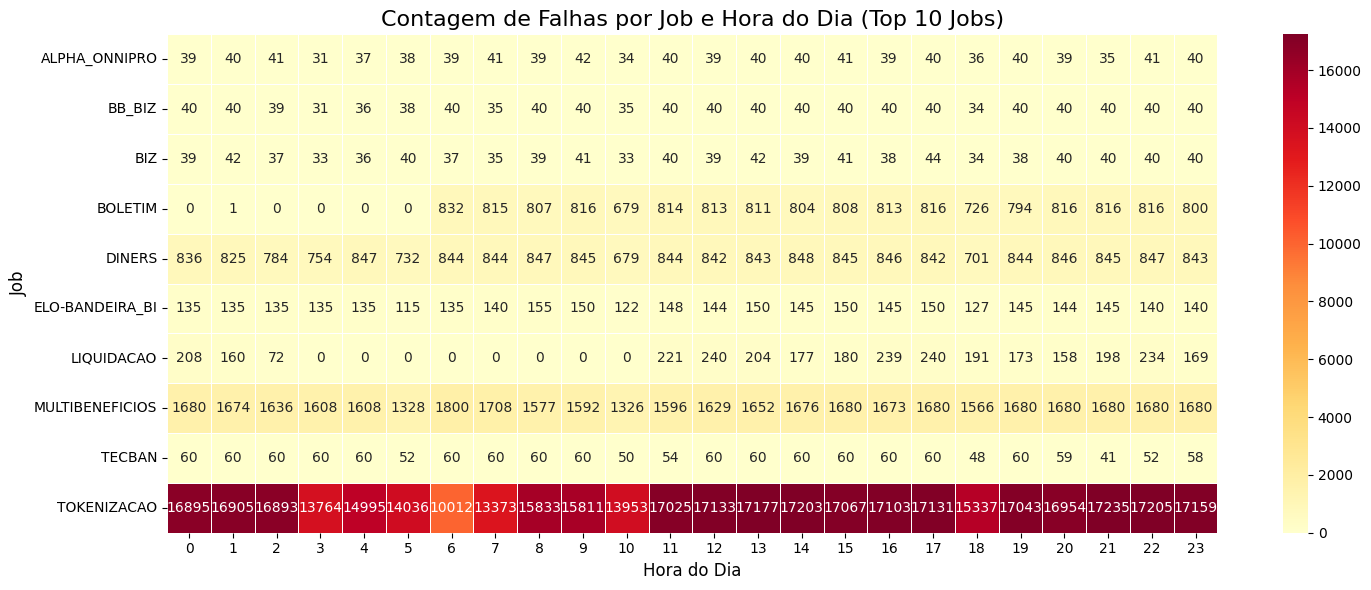

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# Ensure the top_jobs_pivot DataFrame is not empty
if top_jobs_pivot.empty:
    print("[WARN] top_jobs_pivot DataFrame is empty. Cannot generate heatmap.")
else:
    # Convert the DataFrame to integer type for appropriate annotation formatting
    # Use .astype(int) after filling NaNs with 0
    top_jobs_pivot_int = top_jobs_pivot.fillna(0).astype(int)

    # Define figure size based on the number of jobs (rows)
    num_jobs = len(top_jobs_pivot_int)
    fig_height = max(6, num_jobs * 0.5) # Adjust height based on number of jobs
    plt.figure(figsize=(15, fig_height))

    # Create the heatmap with integer formatting
    # Use the integer version of the DataFrame
    sns.heatmap(top_jobs_pivot_int, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5)

    # Add title and labels
    plt.title('Contagem de Falhas por Job e Hora do Dia (Top 10 Jobs)', fontsize=16)
    plt.xlabel('Hora do Dia', fontsize=12)
    plt.ylabel('Job', fontsize=12)

    # Ensure all hours are shown on the x-axis
    plt.xticks(rotation=0) # Keep hour labels horizontal

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

## Refinar a visualização

### Subtask:
Refinar a visualização para torná-la mais adequada para um público executivo.


**Reasoning**:
Refine the heatmap visualization for executive audience by adding a more descriptive title, clear axis labels, adjusting annotation font size, and saving the plot to a file.



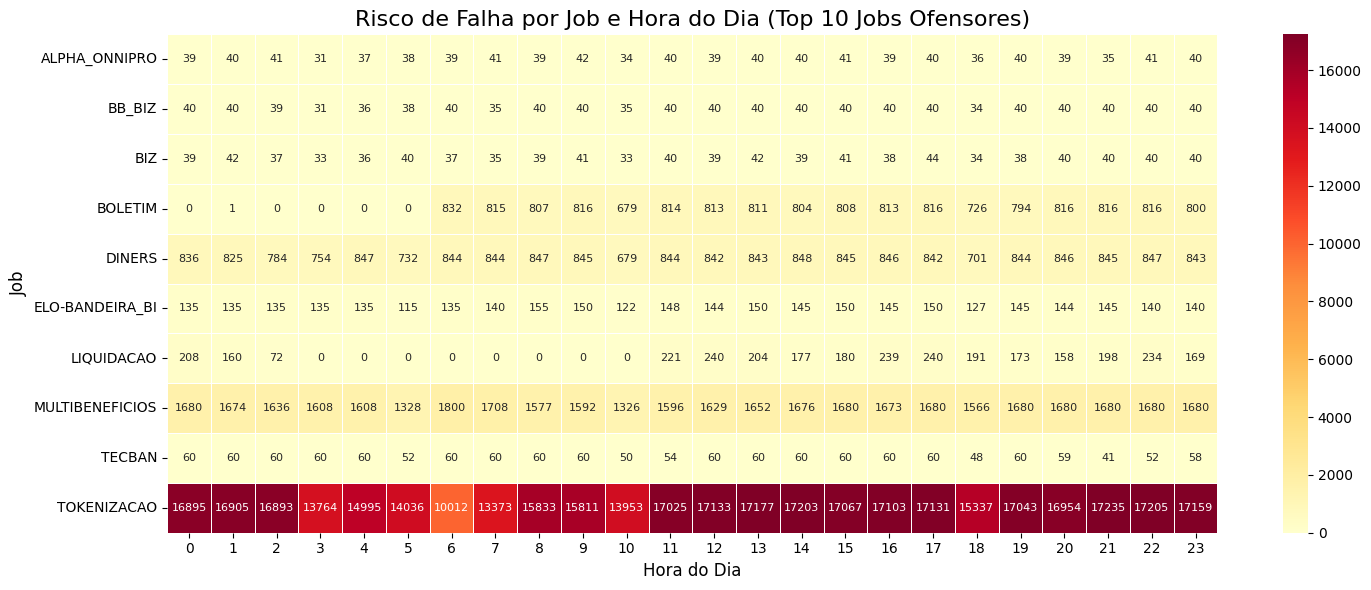

[OK] Gráfico de risco de falha por Job e Hora salvo em: data/heatmap_job_hour_risk_executive.png


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# Ensure the top_jobs_pivot DataFrame is not empty
if top_jobs_pivot.empty:
    print("[WARN] top_jobs_pivot DataFrame is empty. Cannot generate heatmap.")
else:
    # Convert the DataFrame to integer type for appropriate annotation formatting
    # Use .astype(int) after filling NaNs with 0
    top_jobs_pivot_int = top_jobs_pivot.fillna(0).astype(int)

    # Define figure size based on the number of jobs (rows)
    num_jobs = len(top_jobs_pivot_int)
    fig_height = max(6, num_jobs * 0.6) # Adjust height based on number of jobs, slightly increased for better spacing
    plt.figure(figsize=(15, fig_height))

    # Create the heatmap with integer formatting and adjusted annotation font size
    # Use the integer version of the DataFrame
    sns.heatmap(top_jobs_pivot_int, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5, annot_kws={"size": 8}) # Adjusted annotation size

    # Add title and labels (refined)
    plt.title('Risco de Falha por Job e Hora do Dia (Top 10 Jobs Ofensores)', fontsize=16) # More descriptive title
    plt.xlabel('Hora do Dia', fontsize=12) # Clearer X-axis label
    plt.ylabel('Job', fontsize=12) # Clearer Y-axis label

    # Ensure all hours are shown on the x-axis
    plt.xticks(rotation=0) # Keep hour labels horizontal

    # Add a brief text annotation/legend explaining the color scale (optional but helpful)
    # You could add a text box or use the existing color bar (which is standard for heatmaps)
    # For this executive summary, the color bar is likely sufficient, but adding text is an option:
    # plt.text(24.5, num_jobs * 0.8, 'Cor indica a contagem de falhas\n(Mais escuro = Mais falhas)',
    #          fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


    # Adjust layout
    plt.tight_layout()

    # Save the plot to a file
    output_path = Path("data/heatmap_job_hour_risk_executive.png") # Define output path
    output_path.parent.mkdir(parents=True, exist_ok=True) # Ensure directory exists
    plt.savefig(output_path, dpi=300) # Save with good resolution

    # Display the plot
    plt.show()

    # Add a print statement indicating where the graph was saved
    print(f"[OK] Gráfico de risco de falha por Job e Hora salvo em: {output_path}")

## Resumo
Analisamos logs de execução para identificar jobs com maior incidência de falhas e quando elas ocorrem ao longo do dia. O objetivo é priorizar correções e orientar janelas de execução e capacidade.

### Principais achados da análise

*   Identificamos os 10 jobs com mais falhas considerando o total agregado no período analisado.

*   O job “TOKENIZACAO” apresentou o maior número de falhas entre todos.

*   Foi gerado um heatmap por hora do dia para esses 10 jobs, evidenciando horários de maior risco.

*   O heatmap mostra distribuição horária de falhas com intensidade de cor e anotações numéricas indicando a contagem em cada célula.

### Como interpretar o heatmap (contexto prático)

*   Eixo X: horas do dia (00–23).

*   Eixo Y: top 10 jobs com mais falhas.

*   Cores mais escuras: maior concentração de falhas naquela hora para aquele job.

*   Rótulos numéricos: volume exato de falhas por célula (facilita priorização).

*   Leituras úteis: picos recorrentes (ex.: 02h e 14h), padrões por batch window, correlação com janelas de carga.

### Metodologia resumida (para reprodutibilidade)

*   Fonte: tabela/arquivo de falhas com job_name, timestamp, status (ou equivalente).

*   Top 10: soma de falhas por job_name, ordenação decrescente e seleção dos 10 primeiros.

*   Heatmap: pivot de contagem por job_name × hour(timestamp) e renderização com anotações.

### Insights e próximos passos

*   Analisar causa-raiz dos jobs com maior volume, priorizando horas de pico destacadas no heatmap.

*   Ajustar agendamentos: deslocar execuções dos jobs críticos para horários menos congestionados.

*   Alocar recursos: reforçar CPU/IO/memória nas janelas críticas ou isolar filas/partições.

*   Ranqueamento de ações: combinar impacto (falhas/hora) × custo de correção para definir a sequência de mitigação.

*   Compartilhar o heatmap com executivos para facilitar decisões sobre janelas de execução e alocação de capacidade.

*   Monitoramento contínuo: reemitir o heatmap semanalmente e acompanhar a redução de falhas por hora e por job.